In [1]:
from radpy.stellar import *
from radpy.datareadandformat import *
from radpy.plotting import plot_v2_fit
from radpy.LDfitting import initial_LDfit, run_LDfit
from radpy.UDfitting import initial_UDfit, run_UDfit, udfit_values

In [15]:
def filename_extension(filename, inst_name, verbose=False, debug = False):
    #########################################################################
    # Function: filename_extension                                          #
    # Inputs: filename -> name of data file                                 #
    #         inst_name -> Instrument identifier                            #
    #                      C - Classic                                      #
    #                      P - PAVO                                         #
    #                      V - VEGA                                         #
    #                      M - MIRCX                                        #
    #                      MY - MYSTIC                                      #
    #                      S - SPICA                                        #
    #         verbose -> default is False, if true, allows print statements #
    # Outputs: data frame of the data with the instrument added as a column #
    # What it does:                                                         #
    #         1. Checks what format the file is in                          #
    #         If .csv:                                                      #
    #            2a. Uses pandas.read_csv to read in the file               #
    #            3a. Adds the Instrument column                             #
    #         If .txt:                                                      #
    #            2b. Opens the file and reads in the first line             #
    #            3b. Checks what delimiter the file is using                #
    #            4b. Reads in the file                                      #
    #            5b. Adds the instrument column                             #
    #         If .oifits or .fits:                                          #
    #            2c. uses the oifits_to_pandas function                     #
    #         Returns the dataframe, and number of brackets                 #
    #########################################################################

    if filename.endswith('.csv'):
        df = pd.read_csv(filename)
        df['Instrument'] = [inst_name] * len(df)
        sorted_df = brackets(df, inst_name)
        num_brackets = sorted_df['Bracket'].max()
        print('Number of brackets:', num_brackets)
        return sorted_df, num_brackets
        # return sorted_df
    elif filename.endswith('.txt'):
        header = None
        data_start = 0
        with open(filename, 'r') as f:
            lines = f.readlines()
        for i, line in enumerate(lines):
            if line.strip().startswith('#'):
                # Remove '#' and newline, then split by pipe (or whatever header delimiter you expect)
                header = [col.strip() for col in line.strip()[1:].split('|')]
                data_start = i + 1
                if debug:
                    print(f"Header detected: {header}")
                break

        # Read the data lines (skip header and comments)
        # Drop empty lines and comments
        data_lines = [l for l in lines[data_start:] if l.strip() and not l.strip().startswith('#')]

        # Save to a temp string buffer for pandas
        from io import StringIO
        data_str = ''.join(data_lines)
        df = pd.read_csv(StringIO(data_str), sep=r'\s+', header=None, engine='python')
        if header and len(header) == df.shape[1]:
            df.columns = header
        df['Instrument'] = [inst_name] * len(df)
        sorted_df = brackets(df, inst_name)
        num_brackets = sorted_df['Bracket'].max()
        if verbose:
            print('Number of brackets:', num_brackets)
        return sorted_df, num_brackets


    elif filename.endswith('.oifits') or filename.endswith('.fits'):
        df = oifits_to_pandas(filename, inst_name)
        num_brackets = df['Bracket'].max()
        print('Number of brackets:', num_brackets)
        return df, num_brackets
        # return df

    else:
        header = None
        data_start = 0
        with open(filename, "r") as f:
            lines = f.readlines()
        for i, line in enumerate(lines):
            if line.strip().startswith('#'):
                # Remove '#' and newline, then split by pipe (or whatever header delimiter you expect)
                header = [col.strip() for col in line.strip()[1:].split('|')]
                data_start = i + 1
            if debug:
                print(f"Header detected: {header}")
            break

        # Read the data lines (skip header and comments)
        # Drop empty lines and comments
        data_lines = [l for l in lines[data_start:] if l.strip() and not l.strip().startswith('#')]

        # Save to a temp string buffer for pandas
        from io import StringIO
        data_str = ''.join(data_lines)
        df = pd.read_csv(StringIO(data_str), sep=r'\s+', header=None, engine='python')
        if header and len(header) == df.shape[1]:
            df.columns = header
        df['Instrument'] = [inst_name] * len(df)
        sorted_df = brackets(df, inst_name)
        num_brackets = sorted_df['Bracket'].max()
        if verbose:
            print('Number of brackets:', num_brackets)
        return sorted_df, num_brackets

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from radpy.UDfitting import UDV2
from radpy.LDfitting import V2
plt.rcParams['text.usetex'] = True


# Function to bin the PAVO data
def bin_data(x, y, dy, bin_width=5e6, min_points_per_bin=1):
    ###########################################################################
    # Function: bin_data                                                      #
    # Inputs: x -> the x data to bin                                          #
    #         y -> the y data to bin                                          #
    #         bin_width -> the width of the data bins                         #
    #                      default is 5e6 but can be changed                  #
    #         min_points_per_bin-> ensures every bin has 1 data point in it   #
    #                              to avoid nans and issues                   #
    # Outputs: binned_x, binned_y, and binned_dy                              #
    # What it does:                                                           #
    #       1. ensures the input data are arrays                              #
    #       2. sorts the data to make sure its binning properly               #
    #       3. determines the number of bins needed for the data              #
    #       4. sets the bin indices                                           #
    #       5. goes through the data and assigns the data into a bin          #
    #       6. takes the weighted average of the values in each bin           #
    #       7. appends the weighted average into a list                       #
    #       8. Returns the weighted average of each bin                       #
    ###########################################################################

    # Ensure input is numpy array
    x = np.asarray(x)
    y = np.asarray(y)
    dy = np.asarray(dy)

    # Sort by x
    order = np.argsort(x)
    x, y, dy = x[order], y[order], dy[order]

    min_x = x.min()
    max_x = x.max()
    num_bins = max(1, int(np.ceil((max_x - min_x) / bin_width)))
    if num_bins < 1:
        num_bins = 1

    bins = np.linspace(min_x, max_x, num_bins + 1)
    inds = np.digitize(x, bins, right=True)

    avg_x = []
    avg_y = []
    avg_dy = []
    for i in range(1, len(bins)):
        mask = inds == i
        if np.any(mask) and np.sum(mask) >= min_points_per_bin:
            weights = 1 / dy[mask] ** 2
            # weighted mean for x and y
            wx = np.average(x[mask], weights=weights)
            wy = np.average(y[mask], weights=weights)
            wdy = 1 / np.sqrt(np.sum(weights))
            avg_x.append(wx)
            avg_y.append(wy)
            avg_dy.append(wdy)
    return np.array(avg_x), np.array(avg_y), np.array(avg_dy)

##########################################################################################
def plot_v2_fit(data_dict, star, line_spf = None, ldc_band=None, eq_text=False,
                datasets_to_plot=None, plot_ldmodel=False, plot_udmodel=False,
                to_bin=None, title = None, savefig=None, show=True):
    ###########################################################################
    # Function: plot_v2_fit                                                   #
    # Inputs: data_dict -> dict of InterferometryData objects,                #
    #                    e.g. {'pavo': pavo_obj, ...}                         #
    #         star-> star object with .theta and .ldc* attributes             #
    #                (ldcR, ldcK, etc.), and .V2(line_spf, theta, ldc)        #
    #         line_spf -> x values for model curve                            #
    #         ldc_band -> string (e.g. "ldcR", "ldcK") for which LDC          #
    #                     coefficient to use                                  #
    #         eq_text -> optional string for annotation                       #
    #         datasets_to_plot-> list of keys in data_dict to plot            #
    #                            (default: all)                               #
    #         plot_ldmodel-> bool, whether to plot the ld model curve         #
    #         plot_udmodel -> bool, whether to plot the ud model curve        #
    #         to_bin -> list of kets in data_dict to bin                      #
    #         title -> allows user to set a plot title                        #
    #         savefig-> filename to save, if desired                          #
    #         show-> whether to plt.show()                                    #
    # Outputs: the plot                                                       #
    # What it does:                                                           #
    #        1. Initializes plotting parameters                               #
    #        2. Checks to see what datasets the user wants plotted            #
    #        3. Defines dictionaries for each instrument and the marker,      #
    #           color, label, and alpha value for each one                    #
    #        Starts with the top plot                                         #
    #        4. for each data set, sets the keys for the color, marker, label #
    #           and alpha value                                               #
    #        5. Checks to see if the to_bin has been set                      #
    #        6. if to_bin has been set, plots the unbinned data for each      #
    #           data set, and then bins the data sets indicated then plots    #
    #           those                                                         #
    #        7. If to_bin has not been set, it plots the unbinned data        #
    #        8. For the model, if plot_ldmodel is set, pulls the ldtheta,     #
    #           error on the theta, and the ldcs and calculates the fits for  #
    #           the relevant filter                                           #
    #        9. Plots the model for the filter indicated                      #
    #       10. If eq_text is set, annotates the plot with the theta val      #
    #       11. If plot_udmodel is set, pulls the udtheta and error, and      #
    #           calculates the UD model and plots it                          #
    #       12. If eq_text is set, annotates the plot the theta val           #
    #       Bottom plot:                                                      #
    #       13. For each data set, it pulls the respective keys for the       #
    #           color, label, alpha, and marker for each instrument           #
    #       14. For each data set, checks to see if the to_bin value has been #
    #           set.                                                          #
    #       15. If plot_ldmodel has been set, it calculates the residuals for #
    #           the data and the model for the filter indicated.              #
    #       16. If to_bin has been set, it calculates the residuals for the   #
    #           binned data as well.                                          #
    #       17. If plot_udmodel has been set, it calculates the residuals for #
    #           the data and the ud model.                                    #
    #       18. If to_bin has been set, it calcualtes the residuals for the   #
    #           binned data as well.                                          #
    #       19. Plots the residuals for the unbinned (and binned if set)      #
    #       20. Saves fig if save_fig has been set                            #
    #       21. Shows fig if show has been set.                               #
    ###########################################################################
    plt.rcParams.update({'font.size': 18})
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [10, 3]}, sharex=True)

    if datasets_to_plot is None:
        datasets_to_plot = list(data_dict.keys())

    color_map = {
        'pavo': '#02ccfe',
        'classic': '#738595',
        'vega': '#5edc1f',
        'mircx': '#efc8ff',
        'mystic': '#ff81c0',
        'spica': '#ff964f'
    }
    binned_color_map = {
        'pavo': '#030aa7',
        'classic': '#000000' ,
        'vega': '#028f1e',
        'mircx': '#7e1e9c',
        'mystic': '#ff028d',
        'spica': '#fe4b03'
    }
    marker_map = {
        'pavo': '.',
        'classic': 's',
        'vega': '^',
        'mircx': 'o',
        'mystic': '*',
        'spica': 'D'
    }
    label_map = {
        'pavo': r'$\rm PAVO$',
        'classic': r'$\rm Classic$',
        'vega': r'$\rm VEGA$',
        'mircx': r'$\rm MIRC-X$',
        'mystic': r'$\rm MYSTIC$',
        'spica': r'$\rm SPICA$'
    }
    alpha_map = {
        'pavo': 0.25,
        'classic': 0.25,
        'vega': 0.25,
        'mircx': 0.25,
        'mystic': 0.25,
        'spica': 0.25
    }

    if line_spf is None:
        all_spf = []
        for key in datasets_to_plot:
            data = data_dict[key]
            spf = np.array(data.B) / np.array(data.Wave)
            all_spf.extend(spf)
        all_spf = np.array(all_spf)
        max_spf = np.max(all_spf)
        line_spf = np.linspace(0.00001, max_spf*1.1, 1000)  # slight padding
    # --- Top: V2 ---
    for key in datasets_to_plot:
        data = data_dict[key]
        color = color_map.get(key, None)
        bin_color = binned_color_map.get(key, None)
        marker = marker_map.get(key, '.')
        label = label_map.get(key, key.capitalize())
        alpha = alpha_map.get(key, 0.5)
        spf = np.array(data.B) / np.array(data.Wave)
        
        is_binned = to_bin and key in to_bin
        # Always plot both, but only one gets the label
        if is_binned:
            # Plot unbinned points, no label
            a0.plot(spf, data.V2, linestyle='None', marker=marker, markersize=3, color=color, alpha=alpha)
            a0.errorbar(spf, data.V2, yerr=data.dV2, fmt=marker, markersize = 3, linestyle='None', linewidth=0.5, color=color,
                        capsize=3, alpha=alpha)
            # Plot binned points, with label
            binned_spf, binned_v2, binned_dv2 = bin_data(spf, data.V2, data.dV2)
            a0.plot(binned_spf, binned_v2, linestyle='None', marker=marker, markersize=7, color=bin_color, label=label)
            a0.errorbar(binned_spf, binned_v2, yerr=binned_dv2, fmt=marker, linestyle='None', markersize=7, color=bin_color,
                        capsize=3)
        else:
            # Plot unbinned points, with label
            a0.plot(spf, data.V2, linestyle='None', marker=marker, markersize=3, color=color, alpha=alpha, label=label)
            a0.errorbar(spf, data.V2, yerr=data.dV2, fmt=marker, markersize = 3, linestyle='None', linewidth=0.5, color=color,
                        capsize=3, alpha=alpha)
    # --- Model ---
    if plot_ldmodel:
        ldc_value = getattr(star, ldc_band, None)
        theta = getattr(star, "ldtheta", None)
        dtheta = getattr(star, "ldtheta_err", None)
        if ldc_value is not None and theta is not None:
            model_label = fr"$ \rm Model ({ldc_band.replace('ldc_', '').upper()})$"
            a0.plot(line_spf, V2(line_spf, theta, ldc_value), '--', color='black', label=model_label)
            if eq_text:
                eq1 = fr"$\theta_{{\rm LD}} = {round(theta, 3)} \pm {round(dtheta, 3)} \rm ~[mas]$"
                a0.text(0.05,0.05, eq1, transform = a0.transAxes, color = 'black', fontsize = 15)
        else:
            print(f"Warning: {ldc_band} or ldtheta not present for star, skipping model plot.")

    if plot_udmodel:
        theta = getattr(star, "udtheta", None)
        dtheta = getattr(star, "udtheta_err", None)
        if theta is not None:
            model_label = fr"$\rm Uniform~Disk~Model$"
            a0.plot(line_spf, UDV2(line_spf, theta), '--', color='black', label=model_label)
            if eq_text:
                eq1 = fr"$\theta_{{\rm UD}} = {round(theta, 3)} \pm {round(dtheta, 3)} \rm ~[mas]$"
                a0.text(0.05,0.05, eq1, transform = a0.transAxes, color = 'black', fontsize = 15)
        else:
            print(f"Warning: udtheta not present for star, skipping model plot.")

    a0.legend(fontsize=12)
    a0.set_ylabel(r'$V^2$', labelpad=17)
    a0.tick_params(axis='x', labelbottom=False)
    #a0.axis(set_axis)
    a0.xaxis.set_minor_locator(AutoMinorLocator())
    a0.yaxis.set_minor_locator(AutoMinorLocator())

    # --- Bottom panel: Residuals ---
    for key in datasets_to_plot:
        data = data_dict[key]
        color = color_map.get(key, None)
        bin_color = binned_color_map.get(key, None)
        marker = marker_map.get(key, '.')
        alpha = alpha_map.get(key, 0.5)
        spf = np.array(data.B) / np.array(data.Wave)

        is_binned = to_bin and key in to_bin  # e.g. to_bin = ['pavo']

        # --- Model and Residuals for Unbinned ---
        if plot_ldmodel and ldc_value is not None and theta is not None:
            model_v2 = V2(spf, theta, ldc_value)
            residuals = np.array(data.V2) - model_v2
            a1.plot(spf, residuals, linestyle='None', marker=marker, markersize=3, color=color, alpha=alpha)
            a1.errorbar(spf, residuals, yerr=data.dV2, fmt=marker, markersize = 3, linestyle='None', linewidth=0.5, color=color,
                        capsize=3, alpha=alpha)

            # --- Model and Residuals for Binned ---
            if is_binned:
                model_binv2 = V2(binned_spf, theta, ldc_value)
                binned_res = binned_v2 - model_binv2
                a1.plot(binned_spf, binned_res, linestyle='None', marker=marker, markersize=7, color=bin_color)
                a1.errorbar(binned_spf, binned_res, yerr=binned_dv2, fmt=marker, linestyle='None', markersize=7,
                            color=bin_color, capsize=3)

        # --- (Repeat similar for UD model if desired) ---
        if plot_udmodel and theta is not None:
            model_udv2 = UDV2(spf, theta)
            ud_res = np.array(data.V2) - model_udv2
            a1.plot(spf, ud_res, linestyle='None', marker=marker, markersize=3, color=color, alpha=alpha)
            a1.errorbar(spf, ud_res, yerr=data.dV2, fmt=marker, markersize = 3, linestyle='None', linewidth=0.5, color=color, capsize=5,
                        alpha=alpha)

            if is_binned:
                model_binudv2 = UDV2(binned_spf, theta)
                binned_udres = binned_v2 - model_binudv2
                a1.plot(binned_spf, binned_udres, linestyle='None', marker=marker, markersize=7, color=bin_color)
                a1.errorbar(binned_spf, binned_udres, yerr=binned_dv2, fmt=marker, linestyle='None', markersize=7,
                            color=bin_color, capsize=3)

    a1.axhline(y=0, color='black',linestyle = '--')
    a1.set_ylabel(r'$\rm Residual$', labelpad=3)
    plt.yticks([-.25, 0, 0.25])
    a1.set_ylim([-0.35, 0.35])
    a1.xaxis.set_minor_locator(AutoMinorLocator())
    a1.yaxis.set_minor_locator(AutoMinorLocator())

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.xlabel(r'$\rm Spatial$ $\rm frequency$ [$\rm rad^{-1}$]')
    a0.set_title(rf'$\rm {title}$')
    if savefig:
        f.savefig(savefig, bbox_inches='tight')
    if show:
        plt.show()
    return f, (a0, a1)

In [46]:
def extract_id(star_name):
    import re
    match = re.search(r'\d+', star_name)
    return match.group(0) if match else None

def find_files_for_star(star_id, data_dir):
    matches = []
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if star_id in file:
                matches.append(os.path.join(root, file))
    return matches

def extract_instrument_from_filename(filename):
    instruments = {'C': 'classic', 'P': 'pavo', 'V': 'vega', 'M': 'mircx', 'MY': 'mystic', 'S': 'spica'}
    name = os.path.basename(filename).upper()
    # Try to detect instrument by filename
    if "PAVO" in name: return "P"
    if "VEGA" in name: return "V"
    if "CLASSIC" in name or "CLIMB" in name: return "C"
    if "MIRCX" in name: return "M"
    if "MYSTIC" in name: return "MY"
    if "SPICA" in name: return "S"
    # Fallback: use first letter prefix
    for key in instruments:
        if name.startswith(key):
            return key
    return "UNKNOWN"

def save_plot(fig, out_dir, star_id, plot_type, extension):
    os.makedirs(out_dir, exist_ok=True)
    if extension == '.png':
        fig.savefig(os.path.join(out_dir, f"{star_id}_{plot_type}.png"), bbox_inches = 'tight', dpi = 200)
    if extension == '.jpg':
        fig.savefig(os.path.join(out_dir, f"{star_id}_{plot_type}.jpg"), bbox_inches='tight', dpi = 200)
    if extension == '.eps':
        fig.savefig(os.path.join(out_dir, f"{star_id}_{plot_type}.eps"), bbox_inches='tight', dpi = 200)
    if extension == '.pdf':
        fig.savefig(os.path.join(out_dir, f"{star_id}_{plot_type}.pdf"), bbox_inches='tight', dpi = 200)
        
def write_latex_table(df, out_file):
    with open(out_file, "w") as f:
        f.write(df.to_latex(index=False, float_format="%.4f"))

def get_stellar_params(csv_path):
    """
    Read stellar parameters for each star from a CSV with columns:
    star_name, fbol, fbol_err, logg, logg_err, feh, feh_err
    """
    df = pd.read_csv(csv_path, sep='\t')
    star_names = df['Star'].tolist()
    params_dict = {}
    for _, row in df.iterrows():
        params_dict[row['Star']] = {
            'fbol': row['fbol'],
            'fbol_err': row['dfbol'],
            'logg': row['logg'],
            'logg_err': row['dlogg'],
            'feh': row['feh'],
            'feh_err': row['dfeh'],
        }
    return star_names, params_dict
    
def converttoIDobj(dfs, verbose = False):
    #Allows for dynamic wrapping of the different instrument classes
    instrument_class_map = {
        "P": PavoData,
        "V": VegaData,
        "C": ClassicData,
        "M": MircxData,
        #"My": MysticData,
        #"S": SpicaData
    }
    wrapped_data = {}
    for inst_code, df in dfs.items():
        data_class = instrument_class_map.get(inst_code)
        if data_class:
            try:
                wrapped_data[inst_code] = data_class(df)
            except Exception as e:
                print(f"Failed to wrap data for {inst_code}: {e}")
        else:
            print(f"No class found for '{inst_code}'")
    return wrapped_data

def data_dict_plotting(wrapped_data):
    instrument_name_map = {
        "P": "pavo",
        "V": "vega",
        "C": "classic",
        "M": "mircx",
        "My": "mystic",
        "S": "spica"
    }

    data_dict = {
        instrument_name_map[code]: data
        for code, data in wrapped_data.items()
        if code in instrument_name_map
    }

    return data_dict

def process_star(star_name, data_dir, output_dir, stellar_param_dict, latex_rows, mc_num = 71, bs_num = 71,
                 image_ext = None, binned = None, ldc_band = None, verbose=True):
    
    star_id = extract_id(star_name)
    print("--------------------------------------------------")
    print(f"Starting processing for {star_name}")
    files = find_files_for_star(star_id, data_dir)
    if not files:
        print(f"No files found for {star_name} ({star_id})")
        return

    # Group files by instrument
    grouped_files = {}
    for file in files:
        inst = extract_instrument_from_filename(file)
        grouped_files.setdefault(inst, []).append(file)

    # Process files by instrument
    dataframes = {}
    for inst, filelist in grouped_files.items():
        dfs = []
        for file in filelist:
            try:
                df, _ = filename_extension(file, inst, verbose=verbose)
                dfs.append(df)
            except Exception as e:
                print(f"Failed to process {file} ({inst}): {e}")
        if dfs:
            # Concatenate all files for this instrument
            dataframes[inst] = pd.concat(dfs, ignore_index=True)

    # Convert to InterferometryData objects and wrap into instrument classes
    wrap_data = converttoIDobj(dataframes, verbose = False)

    # Combine all available data using RADPy's combined() utility
    combined_args = [obj.make_df() for obj in wrap_data.values()]
    
    b, v2, dv2, wave, band, brack, inst = combined(*combined_args)
    spf = b / wave

    # Set up stellar parameters
    star = StellarParams()
    params = stellar_param_dict.get(star_name, {})
    for param, value in params.items():
        setattr(star, param, value)
    # Calculate distance
    if params.get('plx', None) is not None:
        D, dD = distances(star_name, plx=params['plx'], dplx=params['plx_err'], verbose=verbose)
        star.dist = D
        star.dist_err = dD
    else:
        D, dD = distances(star_name, verbose=verbose)
        star.dist = D
        star.dist_err = dD

    # Initial fits
    initial_UDfit(spf, v2, dv2, 0.4, star, verbose=verbose)
    initial_LDfit(spf, v2, dv2, star, 'R', verbose=verbose)

    # Monte Carlo uniform-disk fit
    datasets = list(wrap_data.values())
    results_UD = run_UDfit(bs_num, mc_num, datasets=datasets, stellar_params=star)
    udfit_values(spf, v2, dv2, results_UD, stellar_params=star, verbose=verbose)

    # Monte Carlo limb-darkened fit
    run_LDfit(bs_num, mc_num, ogdata=[spf, v2, dv2], datasets=datasets, stellar_params=star, verbose=verbose)

    # Calculate additional stellar parameters
    calc_star_params(star, verbose=verbose)

    # Save plots
    plot_dir = os.path.join(output_dir, "plots")
    os.makedirs(plot_dir, exist_ok=True)

    data_dict = data_dict_plotting(wrap_data)
    if binned:
        bin_only = [k for k in binned if k in data_dict]

    # Uniform disk plot
    fig1, _ = plot_v2_fit(
        data_dict=data_dict,
        star=star,
        datasets_to_plot=list(data_dict.keys()),
        to_bin= bin_only,
        plot_udmodel=True,
        eq_text=True,
        title = f"{star_name}",
        show=False
    )
    save_plot(fig1, plot_dir, star_id, "UDfit", image_ext)
    
    # Limb-darkened R band plot
    fig2, _ = plot_v2_fit(
        data_dict=data_dict,
        star=star,
        datasets_to_plot=list(data_dict.keys()),
        to_bin=bin_only,
        plot_ldmodel=True,
        ldc_band= ldc_band,
        title = f"{star_name}",
        eq_text=True,
        show=False
    )
    save_plot(fig2, plot_dir, star_id, "LDfit", image_ext)

    # Collect results for LaTeX
    latex_rows.append({
        "Star": star_name,
        "D (pc)": star.dist,
        r"$\Delta \rm D (pc)$": star.dist_err,
        r"$\theta_{\rm UD}$ (mas)": star.udtheta,
        r"$\Delta\theta_{\rm UD}$ (mas)": star.udtheta_err,
        r"$\theta_{\rm LD}$ (mas)": star.ldtheta,
        r"$\Delta\theta_{\rm LD}$ (mas)": star.ldtheta_err,
        r"$T_{\rm eff}$ (K)": star.teff,
        r"$\Delta T_{\rm eff}$ (K)": star.teff_err,
        r"$L_{\star} (\rm L_{\odot})$": star.lum,
        r"$\Delta L_{\star} (\rm L_{\odot})$": star.lum_err,
        r"$R_{\star} (\rm R_{\odot})$": star.rad,
        r"$\Delta R_{\star} (\rm R_{\odot})$": star.rad_err,
        r"$\mu_{\rm R}$": star.ldc_R,
        r"$\mu_{\rm K}$": star.ldc_K,
        r"$\mu_{\rm H}$": star.ldc_H,
        r"$\mu_{\rm J}$": star.ldc_J,
    })
    print(f"Finished processing {star_name}")

In [33]:
datadir = "C:\\Users\\oxfor\\Research\\rsadpy\\tests\\Diams\\Test"
param_file = "star_testlist.txt"
outputdir = "C:\\Users\\oxfor\\Research\\rsadpy\\tests\\Diams\\Test\\Results"
latex_out = "Test_results.tex"
import os
os.chdir(datadir)
star_names, star_params = get_stellar_params(param_file)

In [48]:

def batch_mode(star_file, data_dir, output_dir, mc_num = 71, bs_num = 71, image_ext = None, binned = None, ldc_band = None, verbose = True):
    os.chdir(data_dir)
    star_names, star_params = get_stellar_params(star_file)
    latex_rows = []
    count = 0
    for star_name in star_names:
        process_star(star_name, data_dir, output_dir, star_params, latex_rows, mc_num = mc_num, bs_num = bs_num,
                     image_ext = image_ext, binned = binned, ldc_band = ldc_band, verbose = verbose)
        count +=1
    
    latex_df = pd.DataFrame(latex_rows)
    write_latex_table(latex_df, latex_out)
    print(f"Batch complete. Fit {count} stars. Plots in {os.path.join(outputdir, 'plots')}, results in {latex_out}")
    

--------------------------------------------------
Starting processing for HD 1461
Number of brackets: 5
Failed to process C:\Users\oxfor\Research\rsadpy\tests\Diams\Test\Results\plots\1461_LDfit.jpg (UNKNOWN): 'charmap' codec can't decode byte 0x81 in position 251: character maps to <undefined>
Failed to process C:\Users\oxfor\Research\rsadpy\tests\Diams\Test\Results\plots\1461_UDfit.jpg (UNKNOWN): 'charmap' codec can't decode byte 0x81 in position 251: character maps to <undefined>
Found Gaia DR3: Gaia DR3 2430102808294101760
Source ID 2430102808294101760
Corrected parallax: 42.7
Distance: 23.42178 +/- 0.01638 [pc]
Initial fit with lmfit:
[[Model]]
    Model(UDV2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 9
    # data points      = 115
    # variables        = 1
    chi-square         = 114.841334
    reduced chi-square = 1.00738012
    Akaike info crit   = 1.84122456
    Bayesian info crit = 4.58615668
    R-squared          = -16.7096188
[[Variabl

C:\Users\oxfor\anaconda3\lib\site-packages\zero_point\zpt.py:205: UserWarning: The apparent magnitude of one or more of the sources is outside the expected range (6-21 mag). 
                Outside this range, there is no further interpolation, thus the values at 6 or 21 are returned.
  warnings.warn(


Corrected parallax: 152.84
Distance: 6.54286 +/- 0.00212 [pc]
Initial fit with lmfit:
[[Model]]
    Model(UDV2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 461
    # variables        = 1
    chi-square         = 583.593270
    reduced chi-square = 1.26868102
    Akaike info crit   = 110.706678
    Bayesian info crit = 114.840076
    R-squared          = -60.2680353
[[Variables]]
    theta:  1.03756289 +/- 0.00128204 (0.12%) (init = 0.4)
Effective temperature: 5009.86228553209 +/- 49.905957503709715 K
LDC for filter  R : 0.6624945977335985
Initial fit with lmfit:
[[Model]]
    Model(V2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 9
    # data points      = 461
    # variables        = 1
    chi-square         = 578.020520
    reduced chi-square = 1.25656635
    Akaike info crit   = 106.283422
    Bayesian info crit = 110.416820
    R-squared          = -59.6829849
[[Variables]]
    theta:  1.11

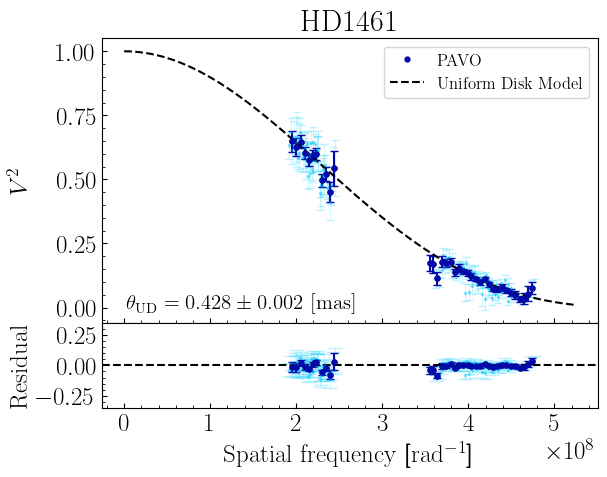

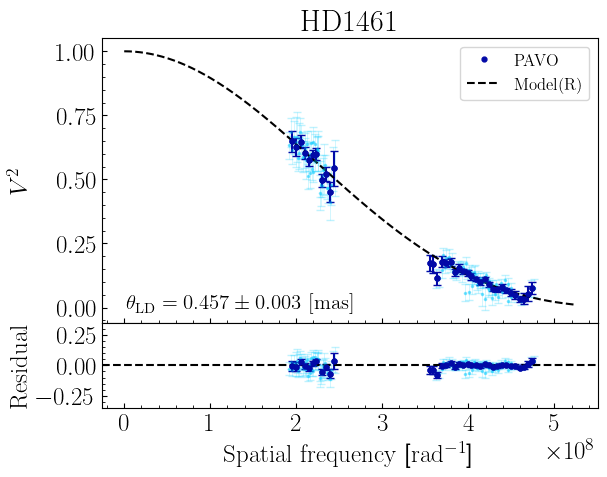

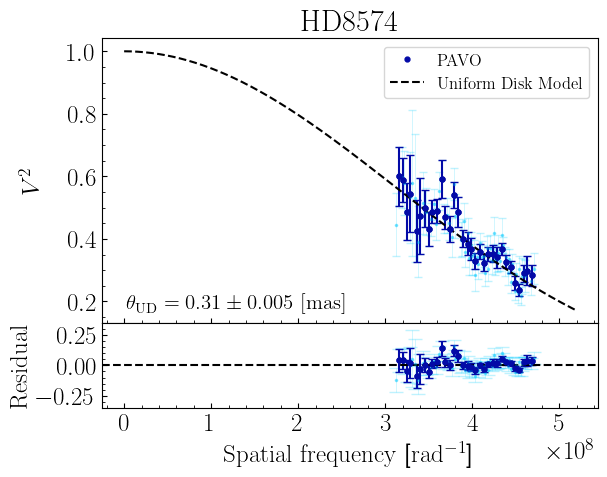

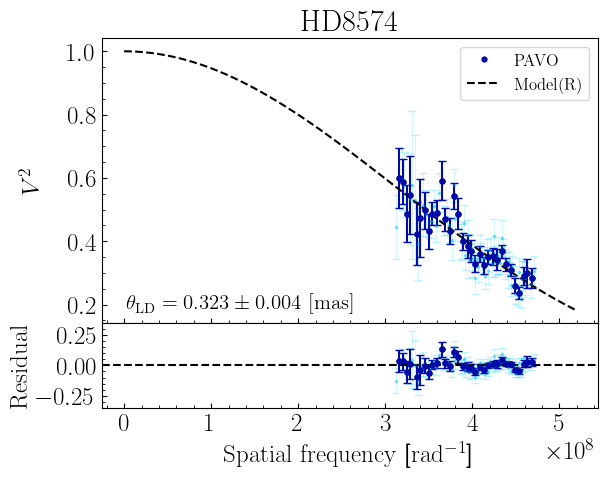

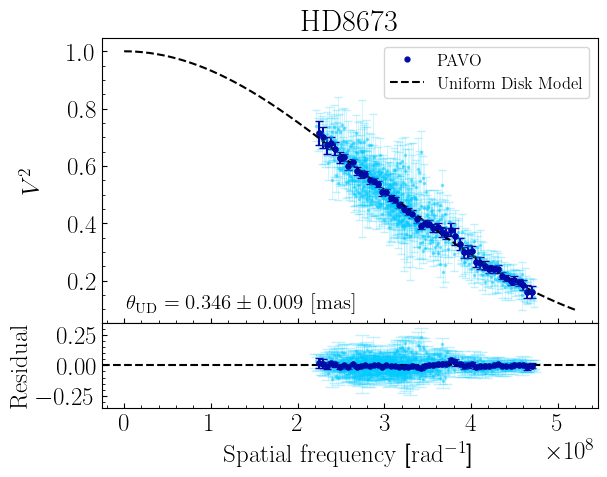

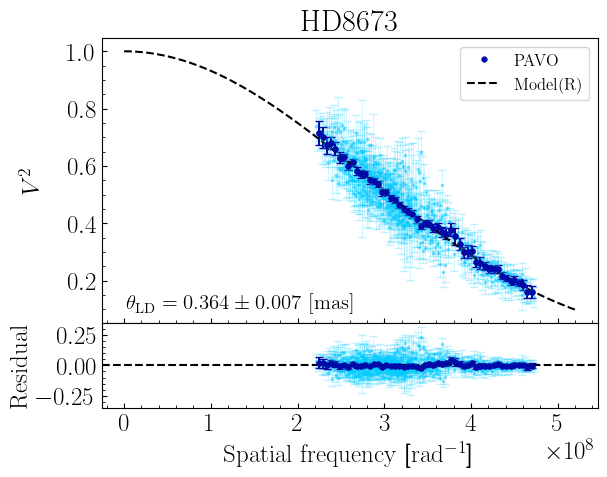

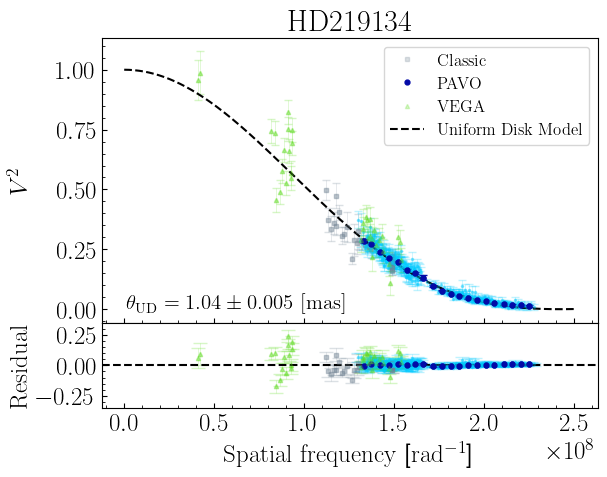

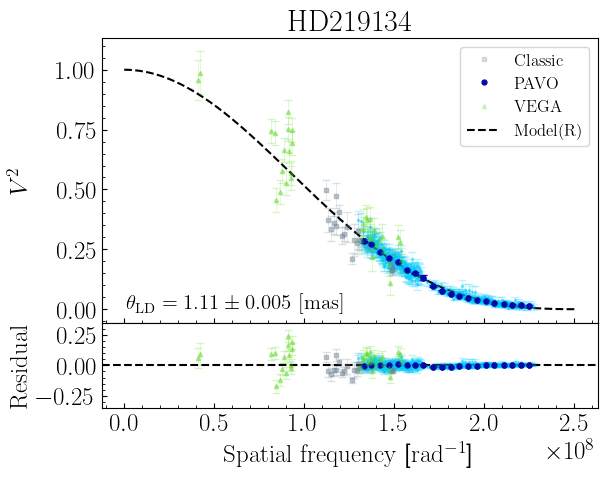

In [50]:
batch_mode(param_file, datadir, outputdir, mc_num = 2, bs_num = 2, image_ext = '.jpg', binned = ['pavo'], ldc_band = 'ldc_R')

--------------------------------------------------
Starting processing for HD 1461
Number of brackets: 5
Failed to process C:\Users\oxfor\Research\rsadpy\tests\Diams\Test\Results\plots\1461_LDfit.jpg (UNKNOWN): 'charmap' codec can't decode byte 0x81 in position 251: character maps to <undefined>
Failed to process C:\Users\oxfor\Research\rsadpy\tests\Diams\Test\Results\plots\1461_UDfit.jpg (UNKNOWN): 'charmap' codec can't decode byte 0x81 in position 251: character maps to <undefined>
Found Gaia DR3: Gaia DR3 2430102808294101760
Source ID 2430102808294101760
Corrected parallax: 42.7
Distance: 23.42178 +/- 0.01638 [pc]
Initial fit with lmfit:
[[Model]]
    Model(UDV2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 9
    # data points      = 115
    # variables        = 1
    chi-square         = 114.841334
    reduced chi-square = 1.00738012
    Akaike info crit   = 1.84122456
    Bayesian info crit = 4.58615668
    R-squared          = -16.7096188
[[Variabl

C:\Users\oxfor\anaconda3\lib\site-packages\zero_point\zpt.py:205: UserWarning: The apparent magnitude of one or more of the sources is outside the expected range (6-21 mag). 
                Outside this range, there is no further interpolation, thus the values at 6 or 21 are returned.
  warnings.warn(


Corrected parallax: 152.84
Distance: 6.54286 +/- 0.00212 [pc]
Initial fit with lmfit:
[[Model]]
    Model(UDV2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 461
    # variables        = 1
    chi-square         = 583.593270
    reduced chi-square = 1.26868102
    Akaike info crit   = 110.706678
    Bayesian info crit = 114.840076
    R-squared          = -60.2680353
[[Variables]]
    theta:  1.03756289 +/- 0.00128204 (0.12%) (init = 0.4)
Effective temperature: 5009.86228553209 +/- 49.905957503709715 K
LDC for filter  R : 0.6624945977335985
Initial fit with lmfit:
[[Model]]
    Model(V2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 9
    # data points      = 461
    # variables        = 1
    chi-square         = 578.020520
    reduced chi-square = 1.25656635
    Akaike info crit   = 106.283422
    Bayesian info crit = 110.416820
    R-squared          = -59.6829849
[[Variables]]
    theta:  1.11

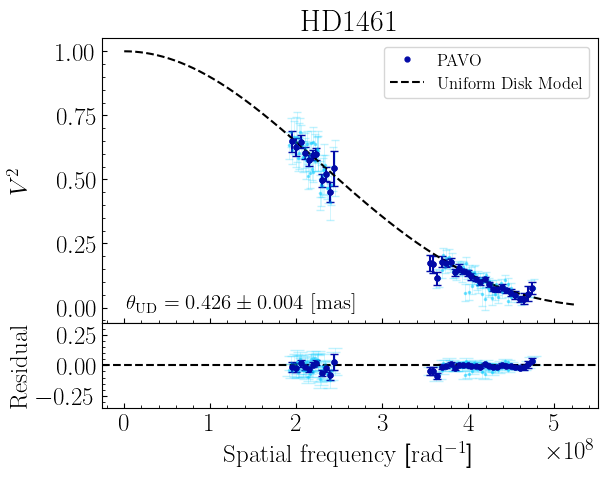

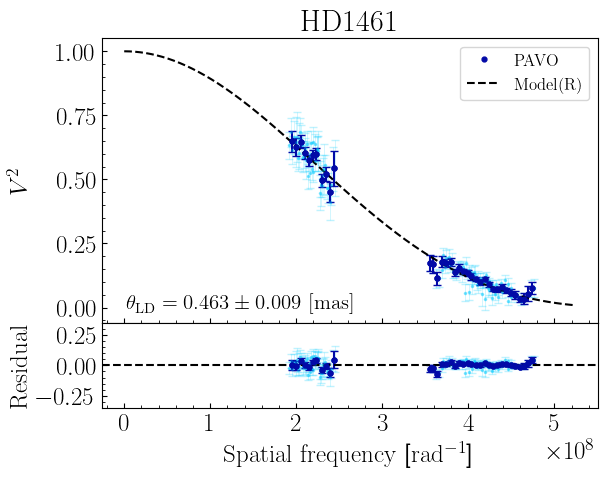

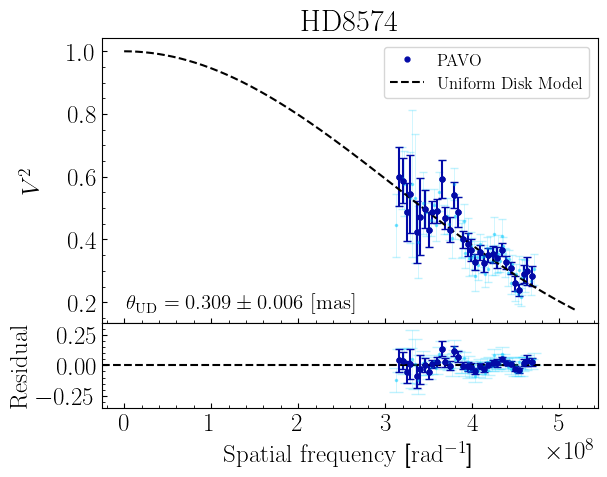

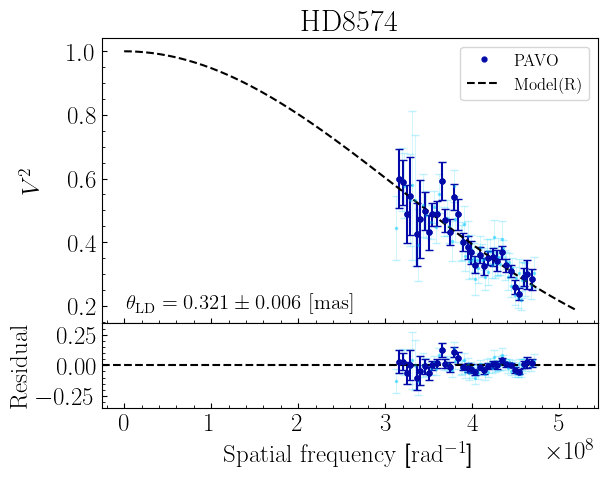

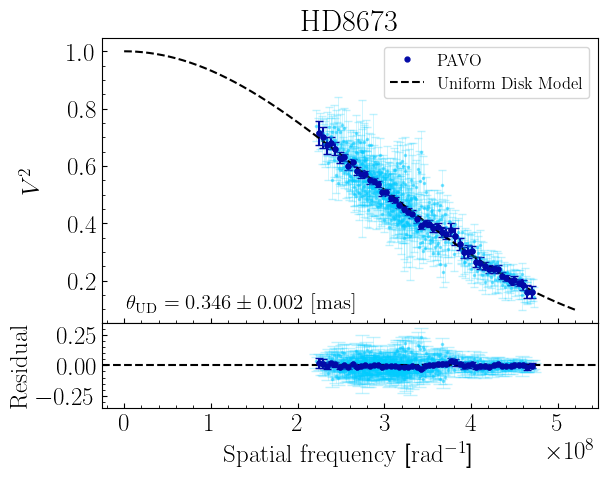

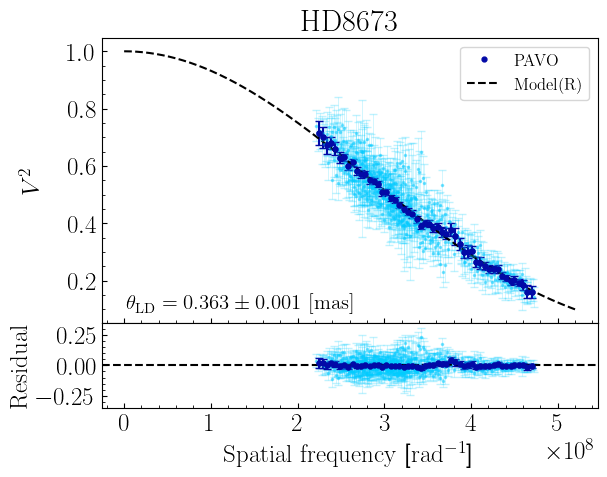

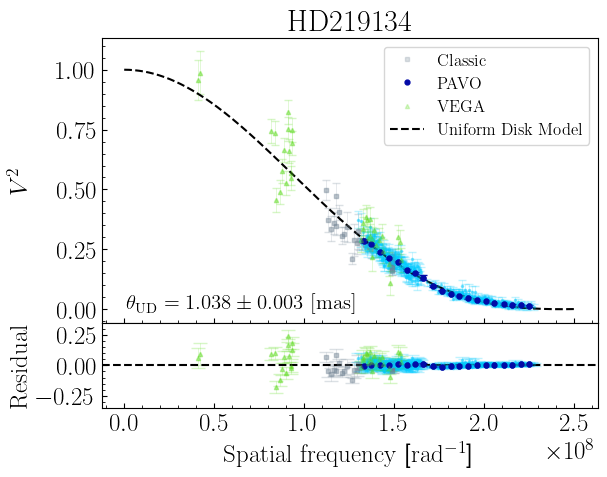

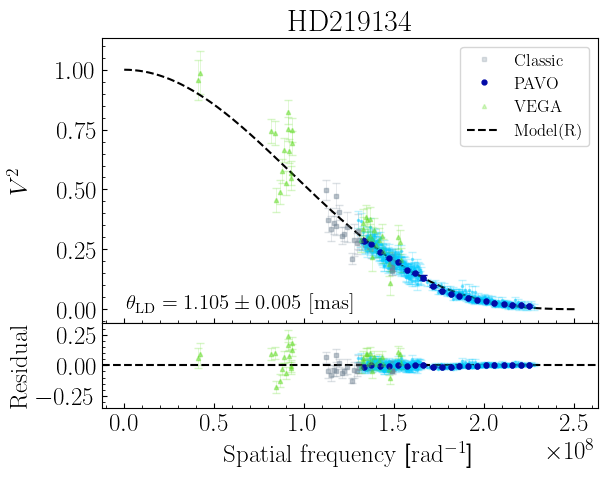

In [47]:
latex_rows = []
for star_name in star_names:
    process_star(star_name, datadir, outputdir, star_params, latex_rows, mc_num = 2, bs_num = 2, image_ext = '.jpg', binned = ['pavo'], ldc_band = 'ldc_R')

In [14]:
latex_df = pd.DataFrame(latex_rows)
#latex_out = 'Test_results.tex'
write_latex_table(latex_df, latex_out)
print(f"Pipeline complete. Plots in {os.path.join(outputdir, 'plots')}, results in {latex_out}")

Pipeline complete. Plots in C:\Users\oxfor\Research\rsadpy\tests\Diams\Test\Results\plots, results in Test_results.tex
